# Gem Hunting
I would like to know the relative frequency with which gems drop for various actions (to compare with combat).
Furthermore, I need to determine if the probability is the same for any action in a subset of actions or
weighted by the base time (like naturalist). The modes to study are
1. Foraging (Root digging)
2. Mining (default)
3. Mining (prospector)
4. Smithing (refining)

#### Foraging (100 gems each)
- [ ] Grasslands (high stats)
- [x] Fungal Grotto
- [x] Haunted (fewer gems)

#### Mining (100 gems base, 10% uncertainty on snr)
- [ ] Clay pit (no prospector)
- [ ] Clay pit (with prospector)
- [ ] Volcano  (no prospector)
- [ ] Volcano  (with prospector)

#### Smithing (all ore from above, hopefully enough stats)
- [ ] Bronze
- [ ] Rune, Mith, Addy

## Prior
It has been stated that for certain actions, the gem drop distribution is `gem_dist = [40, 30, 20, 7, 3]`, and that the
roll is `if( rndm() < gem_chance ) then choice(gem_dist)` so our test statistic can be on total number of gems
rather than sampling each gem independently. With enough data we may be able to test this hypothesis.

In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark-palette")

## Code Stuff

In [2]:
plt.style.use("seaborn-dark-palette")
class GemGatherData:
    def __init__(self, **kwargs):
        self.actions = 1
        self.gems = np.array([1, 0, 0, 0, 0])
        self.enchant = kwargs.get("enchant", 5)
        self.bkg = None
        self._update_()
        
    def _update_(self):
        self.totalGems = sum(self.gems)
        self.apg = self.actions / self.totalGems
        
    def setActionsFromDeltaTime(self, tstart, tstop, timer):
        self.setActions( (tstop - tstart)/timer )
        
    def setActionsFromDeltaEssence(self, estart, estop, **kwargs):
        # Works well for mining, have to be careful with foraging because
        # of farm giving nature essence.
        elvl = kwargs.get("elvl", 5)
        self.setActions( (estop - estart)/elvl )
        
    def setGems(self, gems):
        self.gems = np.array(gems)
        self._update_()
        
    def setActions(self, actions):
        self.actions = actions
        self._update_()
        
    def __add__(self, other):
        combo = GemGatherData()
        combo.actions = self.actions + other.actions
        combo.gems = self.gems + other.gems
        if self.enchant != other.enchant:
            raise ValueError("Cannot add data with different enchant levels")
        combo.enchant = self.enchant
        combo._update_()
        return combo
    
    def getActionProbability(self, **kwargs):
        verbose = kwargs.get("verbose", False)
        tg = self.totalGems
        uncert = tg**0.5
        if self.bkg is not None:
            bgcount = self.bkg.totalGems * self.actions / self.bkg.actions
            bguncert = (self.bkg.totalGems**0.5) * self.actions / self.bkg.actions
            tg = tg - bgcount
            if verbose:
                print(f'Signal Uncertainty: {uncert:0.2f}')
                print(f'Bkg Uncertainty: {bguncert:0.2f}')
            uncert = (uncert**2 + bguncert**2)**0.5
        pval = tg / self.actions / self.enchant
        pvhi = uncert/self.actions/self.enchant
        return pval, pvhi
    
    def report(self):
        #tg = self.totalGems
        #uncert = tg**0.5
        #apg = self.actions/tg * self.enchant
        #apghi = (self.actions * self.enchant)/(tg-uncert) - apg
        #apglow = apg - (self.actions * self.enchant)/(tg+uncert)
        #pval = tg / self.actions / self.enchant
        #print(tg, self.actions, self.enchant)
        #pvhi = uncert/self.actions/self.enchant
        pval, pvhi = self.getActionProbability()
        apg = 1/pval
        apghi = 1/(pval-pvhi) - apg
        apglow = apg - 1/(pval+pvhi)
        print(f'Gem Probability: {pval:0.5f} +- {pvhi:0.5f}')
        print(f'Action-enchant per gem: {apg:0.2f} + {apghi:0.2f} - {apglow:0.2f}')
        
    def setBackgroundDataset(self, bkg, **kwargs):
        self.bkg = bkg 
        verbose = kwargs.get("verbose", False)
        if verbose:
            p, h = self.getActionProbability(verbose=verbose)
            
        
def BackgroundSubtractedGGD(signal, background):
    newggd = GemGatherData(enchant=signal.enchant)
    actionFraction = signal.actions / background.actions
    newggd.setGems( signal.gems - background.gems*actionFraction )
    newggd.actions = signal.actions
    return newggd
        
actionTimer = lambda base, lvl, haste: base * 100 / (99 + lvl) * (1 - 0.04*haste)
        
def plotConfidence(ggd, **kwargs):
    f = lambda x, μ, σ: np.exp(-(x-μ)**2/2/σ**2)/(2*np.pi*σ**2)**0.5
    x = kwargs.pop("x", np.linspace(0, 0.5e-3, 1000))
    bw = x[1] - x[0]
    mu, sigma = ggd.getActionProbability()
    plt.plot(x, f(x, mu, sigma)*bw, **kwargs)
    plt.ylim(bottom=1e-5)
    return mu, sigma

def baseTimerHypothesis(ggdset, baseset, nameset):
    f = lambda x, μ, σ: np.exp(-(x-μ)**2/2/σ**2)/(2*np.pi*σ**2)**0.5
    fig = plt.figure(figsize=(10,8))
    trials = len(ggdset)
    baseMatrix = np.array([np.array(p.getActionProbability())*b for (p,b) in zip(ggdset, baseset)])
    delta = np.sum(baseMatrix, axis=0)[0] - trials*baseMatrix[0][0]
    uncert = np.sum(baseMatrix**2, axis=0)[1]**0.5
    tension = abs(delta / uncert)
    x = np.linspace(0, 1e-2, 1000)
    bw = x[1] - x[0]
    for (bm, name) in zip(baseMatrix, nameset):
        plt.plot(x, f(x, *bm)*bw, label=name)
    plt.ylim(bottom=1e-5)
    plt.title(f'Base timer hypothesis: {tension:0.2f}σ tension')
    plt.xlabel("Base time adjusted probability")
    plt.legend()
    
def gemChi2(ggd, **kwargs):
    plot = kwargs.get("plot", False)
    hypothesis = np.array([0.4, 0.3, 0.2, 0.07, 0.03])*ggd.totalGems
    chi2 = np.sum( (ggd.gems - hypothesis)**2/hypothesis )/(4)
    if plot:
        fig = plt.figure(figsize=(10, 8))
        x = np.array([1, 2, 3, 4, 5])
        axis = ["Sapphire", "Emerald", "Ruby", "Diamond", "Opal"]
        plt.errorbar(x, hypothesis, xerr=(x[2]-x[1])/2, linestyle="None", label="Expected")
        plt.errorbar(x, ggd.gems, yerr=ggd.gems**0.5, xerr=(x[2]-x[1])/2, linestyle="None", label="Data")
        plt.xticks(x, axis)
        plt.ylabel("Total Count")
        plt.ylim(bottom=0)
        plt.legend()
    return chi2

## Foraging Data

Fungal
Gem Probability: 0.00023 +- 0.00003
Action-enchant per gem: 4279.09 + 531.21 - 425.55

Haunted
Gem Probability: 0.00024 +- 0.00004
Action-enchant per gem: 4244.51 + 948.02 - 655.30

Grasslands
Gem Probability: 0.00021 +- 0.00002
Action-enchant per gem: 4729.48 + 395.39 - 338.75

Combined Results
Gem Probability: 0.00022 +- 0.00001
Action-enchant per gem: 4545.62 + 288.92 - 256.33

Gem drop distribution χ^2: 0.32


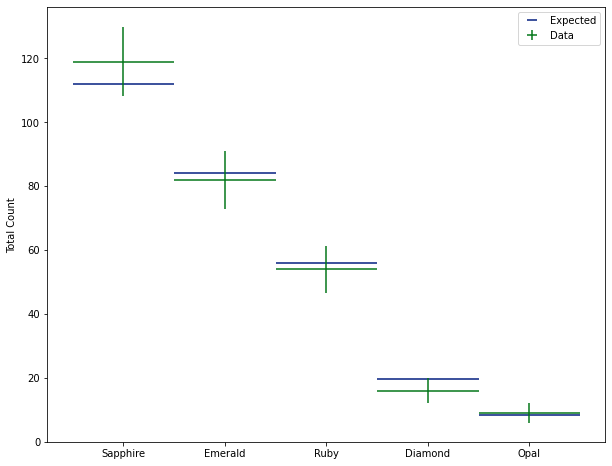

In [3]:
'''
Data collection
'''
## FG
fungal = GemGatherData()
fungal.setActionsFromDeltaTime(1620419087, 1620574242, actionTimer(8, 176, 6))
fungal.setGems([34, 28, 13, 3, 4])
print("Fungal")
fungal.report()

## Haunted
haunted = GemGatherData()
haunted.setActionsFromDeltaTime(1620593916, 1620699106, actionTimer(15, 177, 6))
haunted.setGems([12, 9, 6, 2, 1])
print("\nHaunted")
haunted.report()

## Grasslands
grass = GemGatherData()
grass.setActionsFromDeltaTime(1620707472, 1620969072, actionTimer(6, 178, 6))
grass.setGems([73, 45, 35, 11, 4])
print("\nGrasslands")
grass.report()

combined = fungal + haunted + grass
print("\nCombined Results")
combined.report()

print(f'\nGem drop distribution χ^2: {gemChi2(combined, plot=True):0.2f}')

### Is the probability scaled by base time directly?
Root digging, base timer adjusted hypothesis. This test is to determine if the probability is adjusted
by the base timer or not, results show that the base timer so far does not affect root digging.

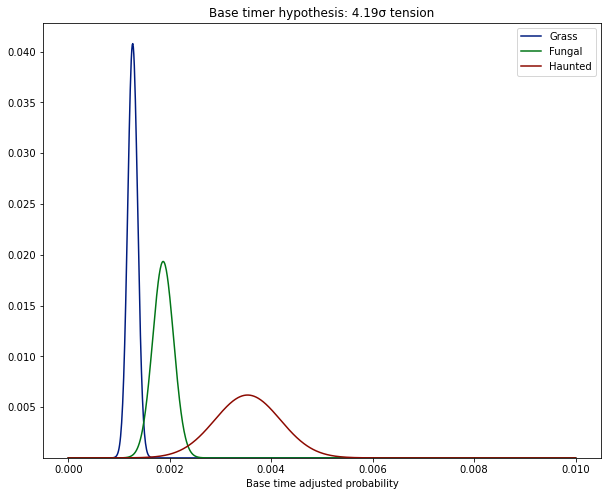

In [4]:
baseTimerHypothesis([grass, fungal, haunted], [6, 8, 15], ["Grass", "Fungal", "Haunted"])
#baseTimerHypothesis([grass, haunted], [6, 15], ["Grass", "Haunted"])
plt.show()

### Action dependent results
Results for the probability to get a gem per action per level of root-digging. For this we assume
that the probability is directly proportional to the enchant level, and that it is the same for
each zone (seems likely given the above tension, but it could have a small zone dependence). I
also assume that the gem drop distribution of [40, 30, 20, 7, 3] (or some other) holds true in
each zone, so that we can base results on total gem drops and not individual drops.

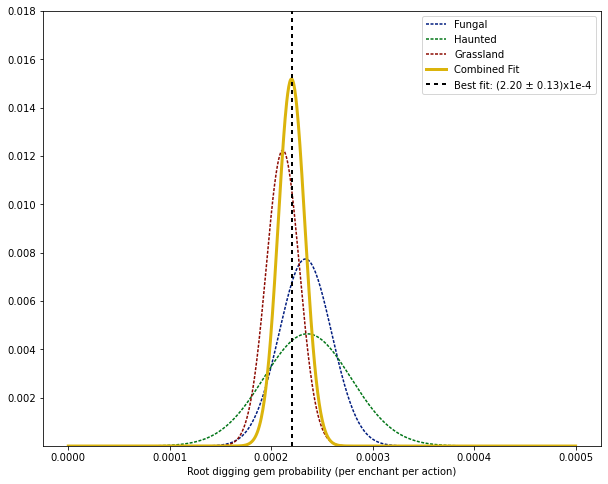

In [5]:
fig = plt.figure(figsize=(10,8))
plotConfidence(fungal,  dashes=[2,1], label="Fungal")
plotConfidence(haunted, dashes=[2,1], label="Haunted")
plotConfidence(grass,   dashes=[2,1], label="Grassland")
m, s = plotConfidence(combined, label="Combined Fit", linewidth=3, color="xkcd:gold")
plt.ylim(top=0.018)
plt.xlabel("Root digging gem probability (per enchant per action)")
plt.axvline(m, color="xkcd:black", label=f'Best fit: ({m * 1e4:0.2f} ± {s * 1e4:0.2f})x1e-4', linewidth=2, dashes=[2,2])
plt.legend()
plt.show()

## Mining Data

** Background dataset **
Gem Probability: 0.00024 +- 0.00005
Action-enchant per gem: 4185.43 + 975.28 - 665.25

** Clay Pit Prospect 6 **
Signal Uncertainty: 14.87
Bkg Uncertainty: 6.39
Gem Probability: 0.00022 +- 0.00002
Action-enchant per gem: 4533.40 + 428.88 - 360.65

Gem drop distribution χ^2: 2.47


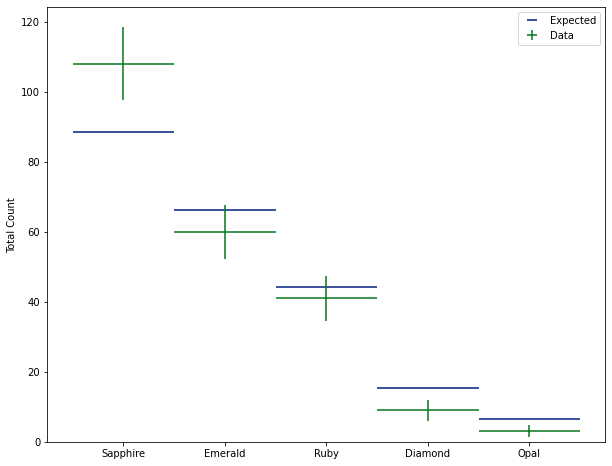

In [6]:
'''
Data Collection: Using essence as mining action proxy.
!-- Pit data is flawed by demon contamination, would need volcano data
'''
pitNoProspectIM = GemGatherData(enchant=1)
pitNoProspectIM.setActionsFromDeltaEssence(1224423, 1367948, elvl=5)
pitNoProspectIM.setGems([3, 2, 3, 0, 0])
#pitNoProspectIM.report()

pitNoProspect = GemGatherData(enchant=1)
pitNoProspect.setActionsFromDeltaEssence(578110, 1008950, elvl=10)
pitNoProspect.setGems([6, 3, 2, 2, 1])
#pitNoProspect.report()

guest = GemGatherData(enchant=1)
guest.setActionsFromDeltaEssence(0, 25719, elvl=1)
guest.setGems([5, 2, 3, 0, 0])

clayNoProspect = GemGatherData(enchant=1)
clayNoProspect.setActionsFromDeltaEssence(1008950, 1923680, elvl=10)
clayNoProspect.setGems([8, 5, 5, 0, 0])

print("** Background dataset **")
combinedNP = clayNoProspect + guest
combinedNP.report()

## Prospector 6
print("\n** Clay Pit Prospect 6 **")
clayProspect = GemGatherData(enchant=6)
clayProspect.setActionsFromDeltaEssence(2058260, 3472720, elvl=10)
clayProspect.setGems(np.array([108, 60, 41, 9, 3]))
clayProspect.setBackgroundDataset(combinedNP, verbose=True)
clayProspect.report()


print(f'\nGem drop distribution χ^2: {gemChi2(clayProspect, plot=True):0.2f}')

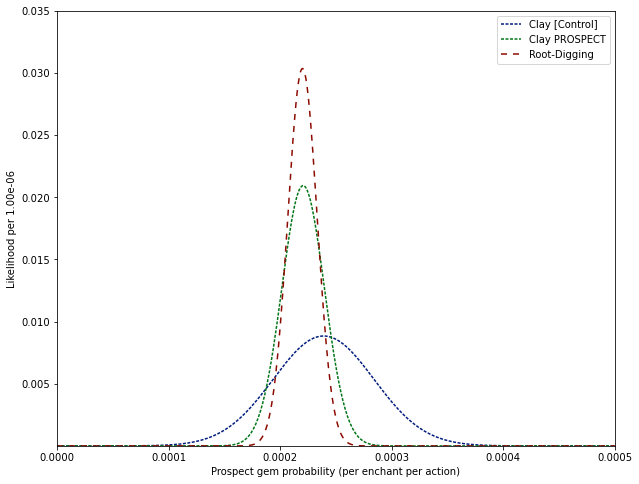

In [7]:
fig = plt.figure(figsize=(10,8))
xbins = np.linspace(0, 1e-3, 1000)
plotConfidence(combinedNP,  dashes=[2,1], label="Clay [Control]", x=xbins)
plotConfidence(clayProspect,  dashes=[2,1], label="Clay PROSPECT", x=xbins)
plotConfidence(combined,   dashes=[4,4], label="Root-Digging", x=xbins)
#m, s = plotConfidence(combinedNP, label="Combined Fit", linewidth=3, color="xkcd:gold", x=xbins)
#plt.axvline(m, color="xkcd:black", label=f'Best fit: ({m * 1e4:0.2f} ± {s * 1e4:0.2f})x1e-4', linewidth=2, dashes=[2,2])
plt.ylim(top=0.035)
plt.xlim(0, 0.0005)
plt.ylabel(f"Likelihood per {xbins[1]-xbins[0]:0.2e}")
plt.xlabel("Prospect gem probability (per enchant per action)")
plt.legend()
plt.show()